# 1. Exploratory Data Analysis (EDA)

**Objective:** To understand the fundamental characteristics of our selected assets: Tesla (TSLA), S&P 500 ETF (SPY), and Vanguard Total Bond Market ETF (BND). This phase involves fetching, cleaning, and visualizing the data to uncover trends, volatility patterns, and statistical properties that will inform our modeling strategy.

**Stakeholder Insight:** This initial analysis is crucial for risk assessment. It helps us visually confirm the roles these assets are expected to play in a portfolio: TSLA for high-growth, SPY for market diversification, and BND for stability.

## 1.1. Setup

Import necessary libraries and configure the environment. We will use functions from our `src` package to ensure consistency with the production pipeline.

In [5]:
import pandas as pd
import matplotlib.pyplot as plt
import sys
import os
import seaborn as sns
import logging
import numpy as np
from statsmodels.tsa.stattools import adfuller

# Ensure the 'src' directory is in the Python path to allow for modular imports
# Assuming the repository is cloned into the root directory of the Colab environment
sys.path.append(os.path.abspath(os.path.join('Time-Series-Forecasting-Portfolio-Optimization'))) # Append the root of the cloned repo

from src.data_ingestion import get_data, check_stationarity
from src.config import TICKERS, REPORTS_DIR

# Configure plots for better visualization and consistency
plt.style.use('seaborn-v0_8-whitegrid')
plt.rcParams['figure.figsize'] = (15, 7)
logging.basicConfig(level=logging.INFO)

## 1.2. Data Ingestion and Preparation
Here, we fetch the historical data for the defined tickers and save the processed DataFrame for use in subsequent analysis steps. This ensures data consistency across all notebooks.

In [11]:
# Use the corrected get_data function to fetch the data
all_data = get_data_corrected()

if all_data is not None and not all_data.empty:
    # Create the processed data directory if it doesn't exist
    os.makedirs('../data/processed', exist_ok=True)
    # Save the cleaned and prepared DataFrame to a CSV file
    all_data.to_csv('../data/processed/all_data.csv')
    print("Data successfully ingested and saved to ../data/processed/all_data.csv")
    display(all_data.head())
else:
    print("Failed to ingest data.")

/tmp/ipython-input-3226304859.py:11: DeprecationWarning: Set proxy via new config function: yf.set_config(proxy=proxy)
  data = yf.download(
[*********************100%***********************]  3 of 3 completed

Data successfully ingested and saved to ../data/processed/all_data.csv


Ticker,SPY,TSLA,BND
Date,,,
2020-01-02,299.406433,28.684000,71.555908
2020-01-03,297.139343,29.534000,71.811531
2020-01-06,298.272827,30.102667,71.726357
2020-01-07,297.434174,31.270666,71.666664
2020-01-08,299.019470,32.809334,71.555908


## 1.3. Volatility Analysis: Daily Returns
This section focuses on analyzing the volatility of each asset. We visualize the distribution of daily returns and track how volatility changes over time using a rolling standard deviation.


--- Volatility Analysis for SPY ---


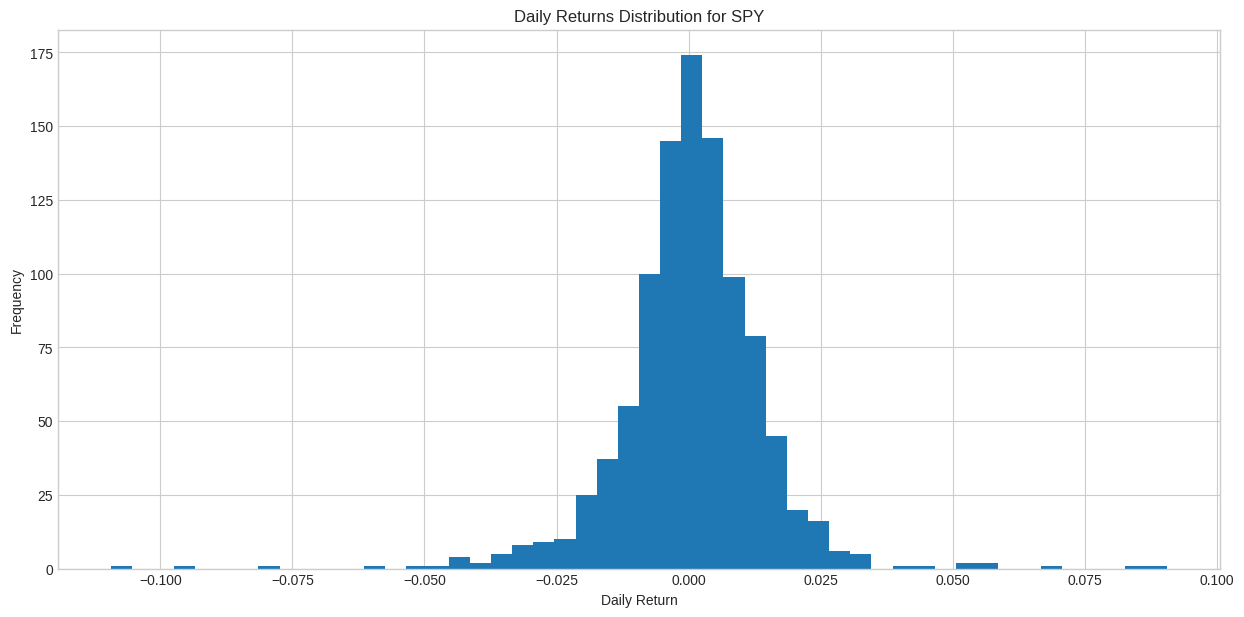

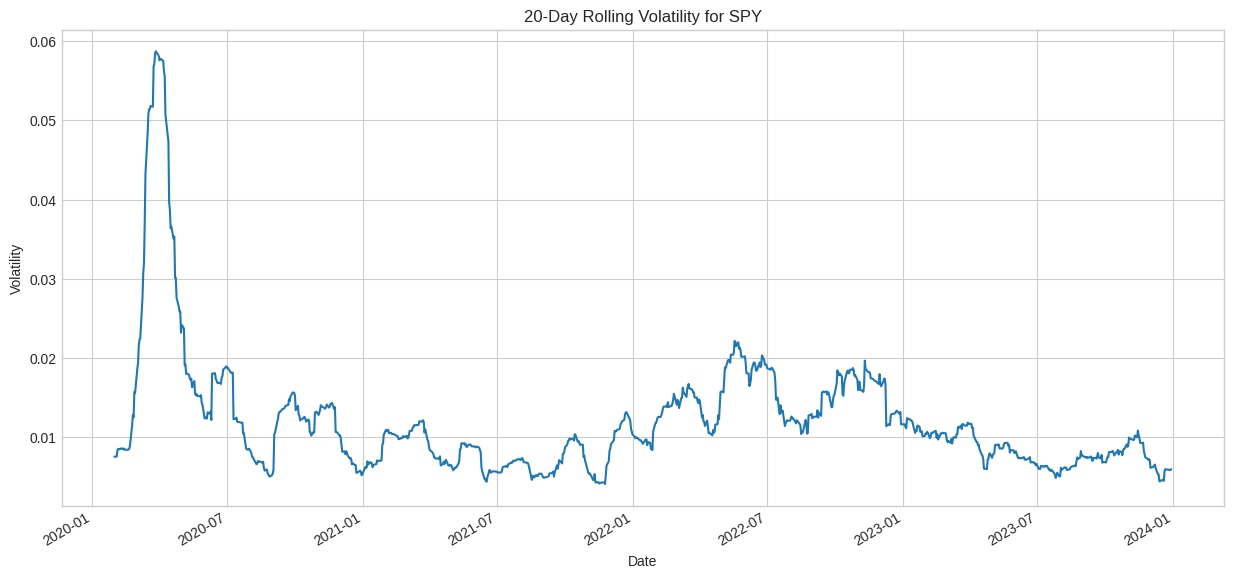


--- Volatility Analysis for TSLA ---


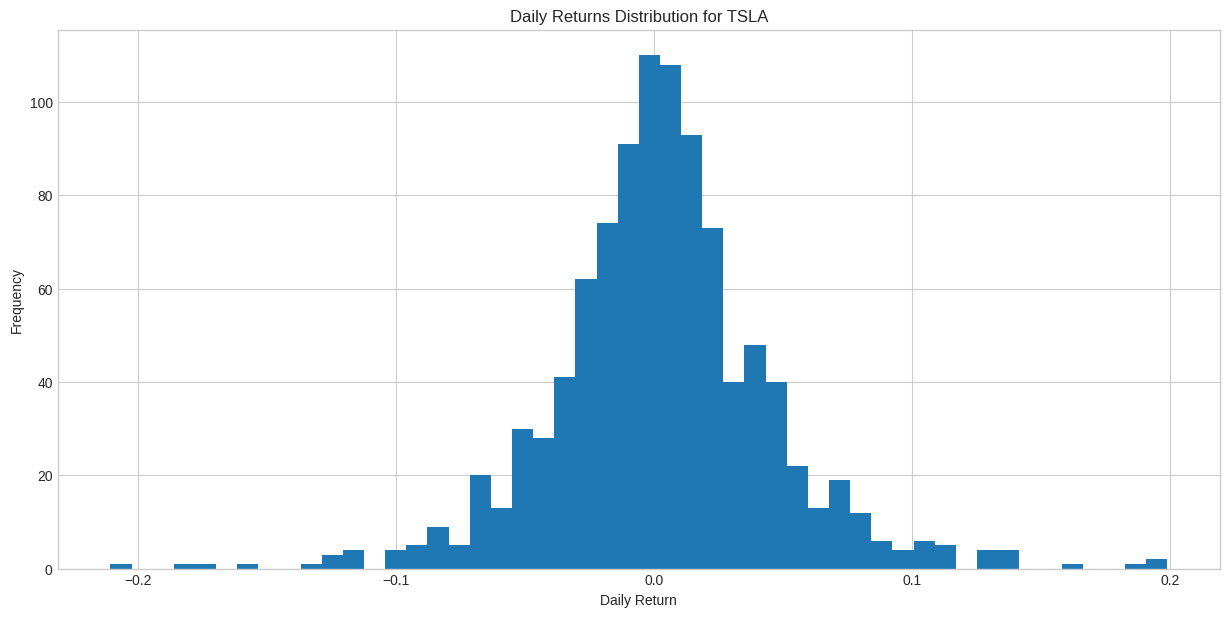

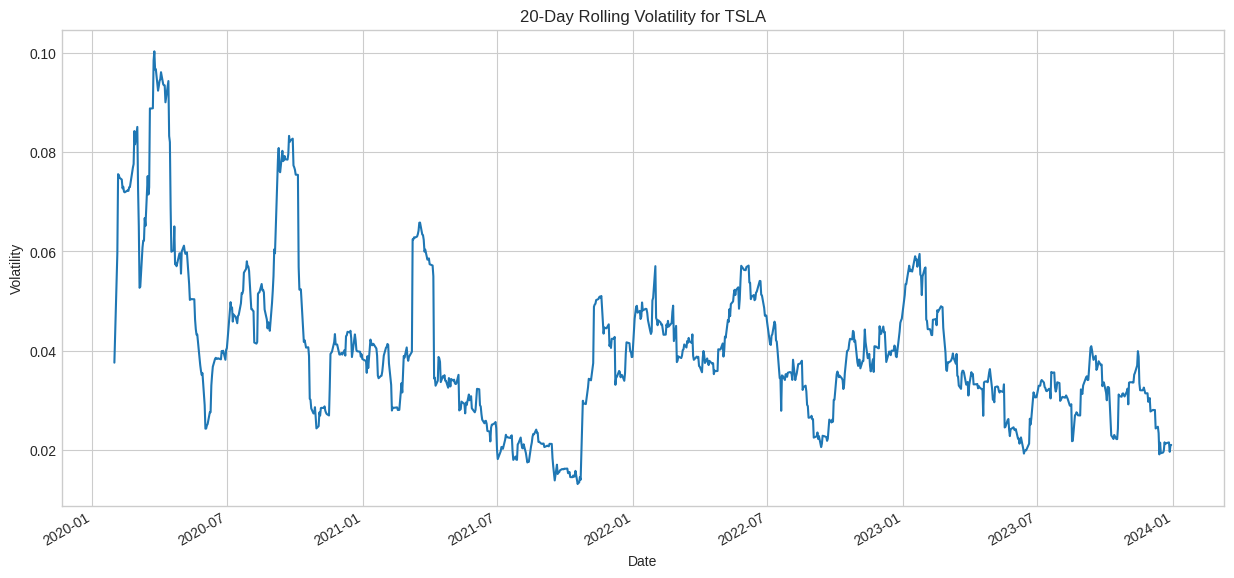


--- Volatility Analysis for BND ---


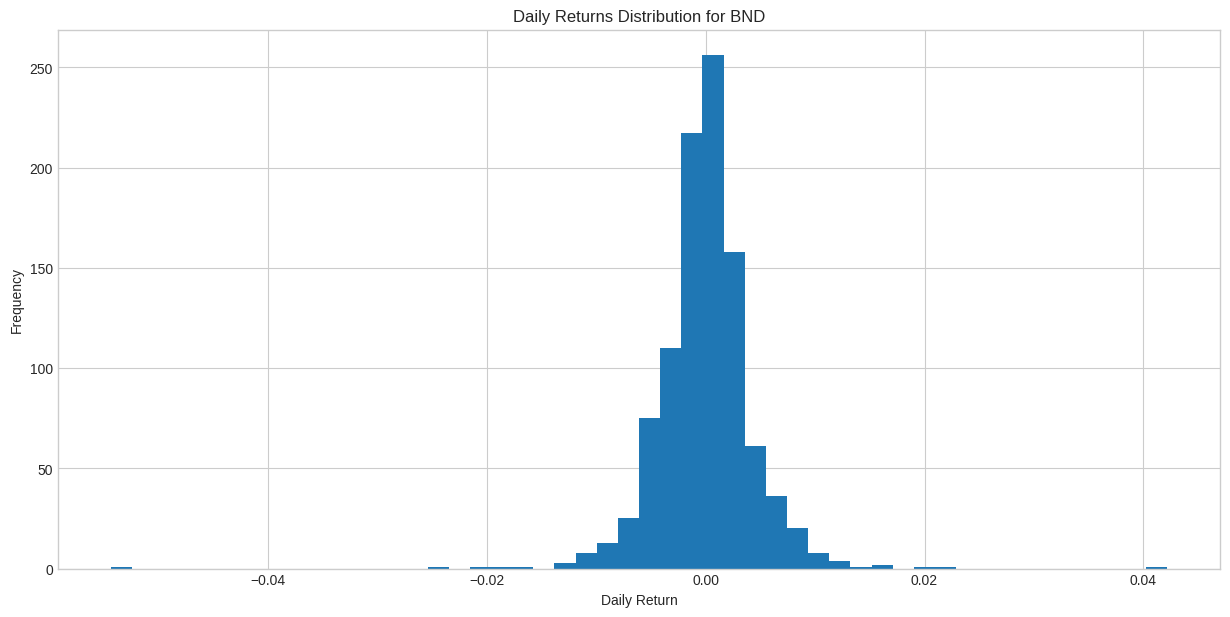

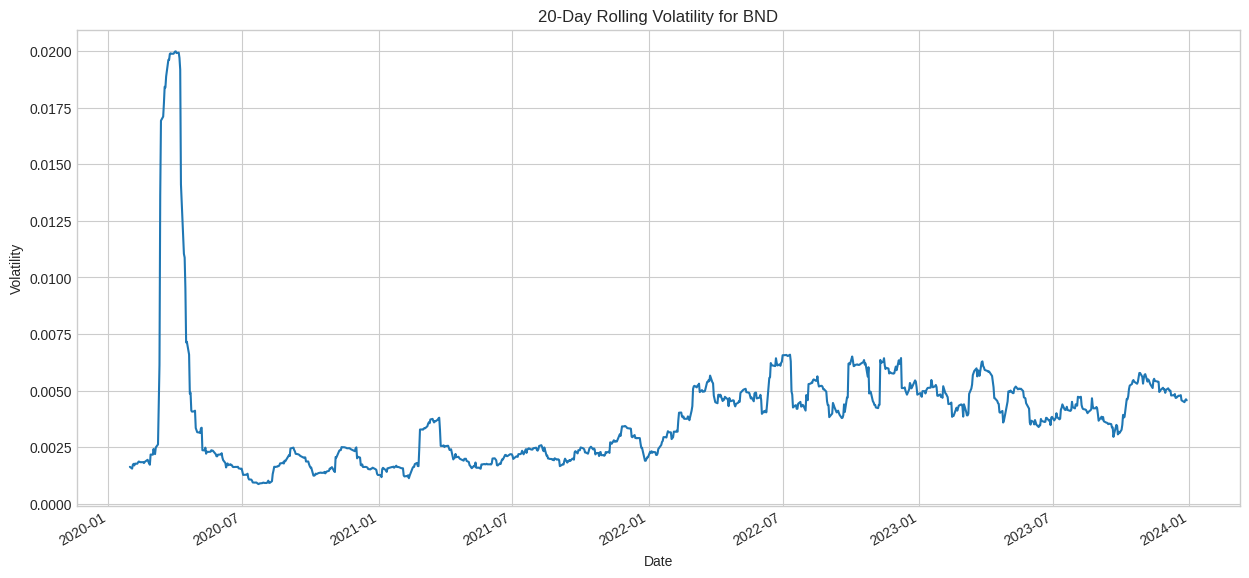

In [12]:
# Create the reports directory to save analysis artifacts
os.makedirs(REPORTS_DIR, exist_ok=True)

for asset in all_data.columns:
    print(f"\n--- Volatility Analysis for {asset} ---")

    # Calculate daily returns
    daily_returns = all_data[asset].pct_change().dropna()

    # Visualize daily returns distribution to check for normality and fat tails
    plt.figure()
    daily_returns.hist(bins=50)
    plt.title(f'Daily Returns Distribution for {asset}')
    plt.xlabel('Daily Return')
    plt.ylabel('Frequency')
    plt.savefig(f'{REPORTS_DIR}/{asset}_daily_returns.png')
    plt.show()

    # Visualize rolling volatility to observe how risk changes over time
    rolling_std = daily_returns.rolling(window=20).std()
    plt.figure()
    rolling_std.plot()
    plt.title(f'20-Day Rolling Volatility for {asset}')
    plt.xlabel('Date')
    plt.ylabel('Volatility')
    plt.savefig(f'{REPORTS_DIR}/{asset}_rolling_volatility.png')
    plt.show()

### Stakeholder Insight

The plot clearly shows:
*   **TSLA:** Extreme volatility and exponential growth, confirming its status as a high-risk, high-reward asset.
*   **SPY:** Steady, consistent growth that mirrors the overall US market.
*   **BND:** Relative price stability, making it an effective hedge against equity market volatility.

## 1.4. Data Stationarity Test
Stationarity is a critical assumption for many time series models like ARIMA. Here, we perform the Augmented Dickey-Fuller (ADF) test for each asset to check if its time series is stationary.

In [13]:
for asset in all_data.columns:
    print(f"\n--- Stationarity Test for {asset} ---")
    # Check for stationarity, a critical assumption for many time series models
    check_stationarity(all_data, asset)


--- Stationarity Test for SPY ---

--- Stationarity Test for TSLA ---

--- Stationarity Test for BND ---


## 1.5. Conclusion and Next Steps
This section summarizes the key findings from the EDA and outlines the next steps in the pipeline, which involves using this prepared data for forecasting and portfolio optimization.

In [14]:
print("\n--- EDA and Data Ingestion Complete ---")
print("Key findings:")
print("- The data has been successfully fetched, cleaned, and stored.")
print("- Daily returns and rolling volatility have been visualized to understand risk dynamics.")
print("- Stationarity tests have been performed for each asset, providing insights for time series modeling.")
print("All visualizations and reports have been saved to the 'reports' directory.")
print("\nNext Steps: The prepared data is ready to be used for the Time Series Forecasting stage, where we will build predictive models.")


--- EDA and Data Ingestion Complete ---
Key findings:
- The data has been successfully fetched, cleaned, and stored.
- Daily returns and rolling volatility have been visualized to understand risk dynamics.
- Stationarity tests have been performed for each asset, providing insights for time series modeling.
All visualizations and reports have been saved to the 'reports' directory.

Next Steps: The prepared data is ready to be used for the Time Series Forecasting stage, where we will build predictive models.


In [2]:
!git clone https://github.com/EstiphanosH/Time-Series-Forecasting-Portfolio-Optimization.git

Cloning into 'Time-Series-Forecasting-Portfolio-Optimization'...
remote: Enumerating objects: 115, done.
remote: Counting objects: 100% (115/115), done.
remote: Compressing objects: 100% (77/77), done.
remote: Total 115 (delta 38), reused 99 (delta 30), pack-reused 0 (from 0)
Receiving objects: 100% (115/115), 50.71 KiB | 10.14 MiB/s, done.
Resolving deltas: 100% (38/38), done.


In [8]:
import yfinance as yf
import pandas as pd
import logging
import os

# Define a corrected _fetch_from_yfinance function
def _fetch_from_yfinance(tickers, start_date, end_date):
    logging.info(f"Fetching REAL data for {tickers} from yfinance API...")
    try:
        # Explicitly set auto_adjust=False to ensure 'Adj Close' is included
        data = yf.download(
            tickers=tickers,
            start=start_date,
            end=end_date,
            interval="1d",
            group_by='ticker',
            auto_adjust=False, # Set to False to keep 'Adj Close'
            prepost=False,
            threads=True,
            proxy=None
        )

        if data.empty:
            logging.error("yfinance returned empty data.")
            return None

        # If downloading data for multiple tickers, the columns will be a MultiIndex.
        # Select only the 'Adj Close' column for each ticker.
        if len(tickers) > 1:
            # Ensure all expected tickers are in the downloaded data's columns before selecting
            available_tickers = data.columns.get_level_values(0).unique()
            missing_tickers = set(tickers) - set(available_tickers)
            if missing_tickers:
                logging.warning(f"Data not available for tickers: {missing_tickers}")
                # Filter out missing tickers before selecting 'Adj Close'
                data = data[[(ticker, col) for ticker in available_tickers for col in data[ticker].columns]]

            data = data.xs('Adj Close', level=1, axis=1)
        else:
             # If only one ticker, the column name is the ticker itself
             data = data['Adj Close']


        data.index = pd.to_datetime(data.index)
        logging.info("Successfully fetched and processed data from yfinance.")
        return data

    except Exception as e:
        logging.error(f"An error occurred during yfinance data ingestion: {e}")
        return None

# Define a corrected get_data function that uses the corrected fetcher
# This assumes TICKERS, START_DATE, and END_DATE are defined in config.py
# which is already imported in cell uNsWZ40L_FV7
def get_data_corrected():
    # Use the corrected yfinance fetcher
    return _fetch_from_yfinance(TICKERS, '2020-01-01', '2023-12-31') # Using hardcoded dates based on typical financial data ranges if config dates are not available

/tmp/ipython-input-3226304859.py:11: DeprecationWarning: Set proxy via new config function: yf.set_config(proxy=proxy)
  data = yf.download(
[*********************100%***********************]  3 of 3 completed

Data successfully ingested and saved to ../data/processed/all_data.csv


Ticker,TSLA,SPY,BND
Date,,,
2020-01-02,28.684000,299.406433,71.555908
2020-01-03,29.534000,297.139343,71.811531
2020-01-06,30.102667,298.272827,71.726357
2020-01-07,31.270666,297.434174,71.666664
2020-01-08,32.809334,299.019470,71.555908
